# FGPA vs Hydro

In this notebook, we compare the FGPA applied on DM-only TNG300-1 with TNG300-1 hydro simulations. 

Literature works :

- FGPA  : 

[Sorini 2016](https://iopscience.iop.org/article/10.3847/0004-637X/827/2/97/pdf)

[Kulkarni 2015](https://iopscience.iop.org/article/10.1088/0004-637X/812/1/30/pdf)


The Volume ratio of TNG300/LATIS :

In [1]:
(63*51*483)/(205**3)

0.1801342406523411

## Generating spectra :

### Steps:

1. CIC-bin the density map
  
  Following the tradition of 1 particle per cell, we have $2500^3$ cells.
  
2. Apply FGPA to get $\tau_{real}$

   1. Smooth density with($\lambda_G$ and velocity with $\lambda_v$
   
     Drew did not smooth the DM for N-body planck with $\sim 228 ckpc$ spatial resolution.
   
   2. Calculate Temperature $T = T_0 (1 + \delta_b)^{\gamma - 1 }$
   
   3. Calculate $ n_{HI} \propto (1+\delta_b)^{2-0.7(\gamma -1)}$
   
   4. $\tau_{real} (u) = \frac{\lambda_{Ly\alpha} \sigma}{H(z)}n_{HI}(u)$
   
      

3. Convolution with Gasussian approximation of the Voight profile

    - The intergral's limits ? Along the whole line of sight ? Yes
    - Just generate the mesh in real space with $\sim 2500^3$ grids. Also save the $v_{pec}$ of each voxel. Then
      cacluate the convolution below :
    
        $\tau(u) = \frac{\lambda_{Ly\alpha} \sigma}{H(z)} \int du^{\prime} \frac{n_{HI}(u^{\prime})}{b(u^{\prime})} exp[-(\frac{ (u - u^{\prime} - u_{pec})}{b(u^{\prime})})^2]$
         
        - This kernel is not constant for all pixel along the los. So, we calculate convolution manually. 
        
        - Periodc boundary should be applied 


4. Fix the amplitude with mean flux or 1D power. 

5. Resampling the pixels to larger sizes : By averaging the flux within each larger pixel


In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('Notebook.mystyle')
from astropy.cosmology import Planck15 as cosmo
from scipy.ndimage import gaussian_filter
from scipy.ndimage import gaussian_filter1d

### $\tau_{real}$ vs $\tau_{conv}$

2.4442257045541464
2460


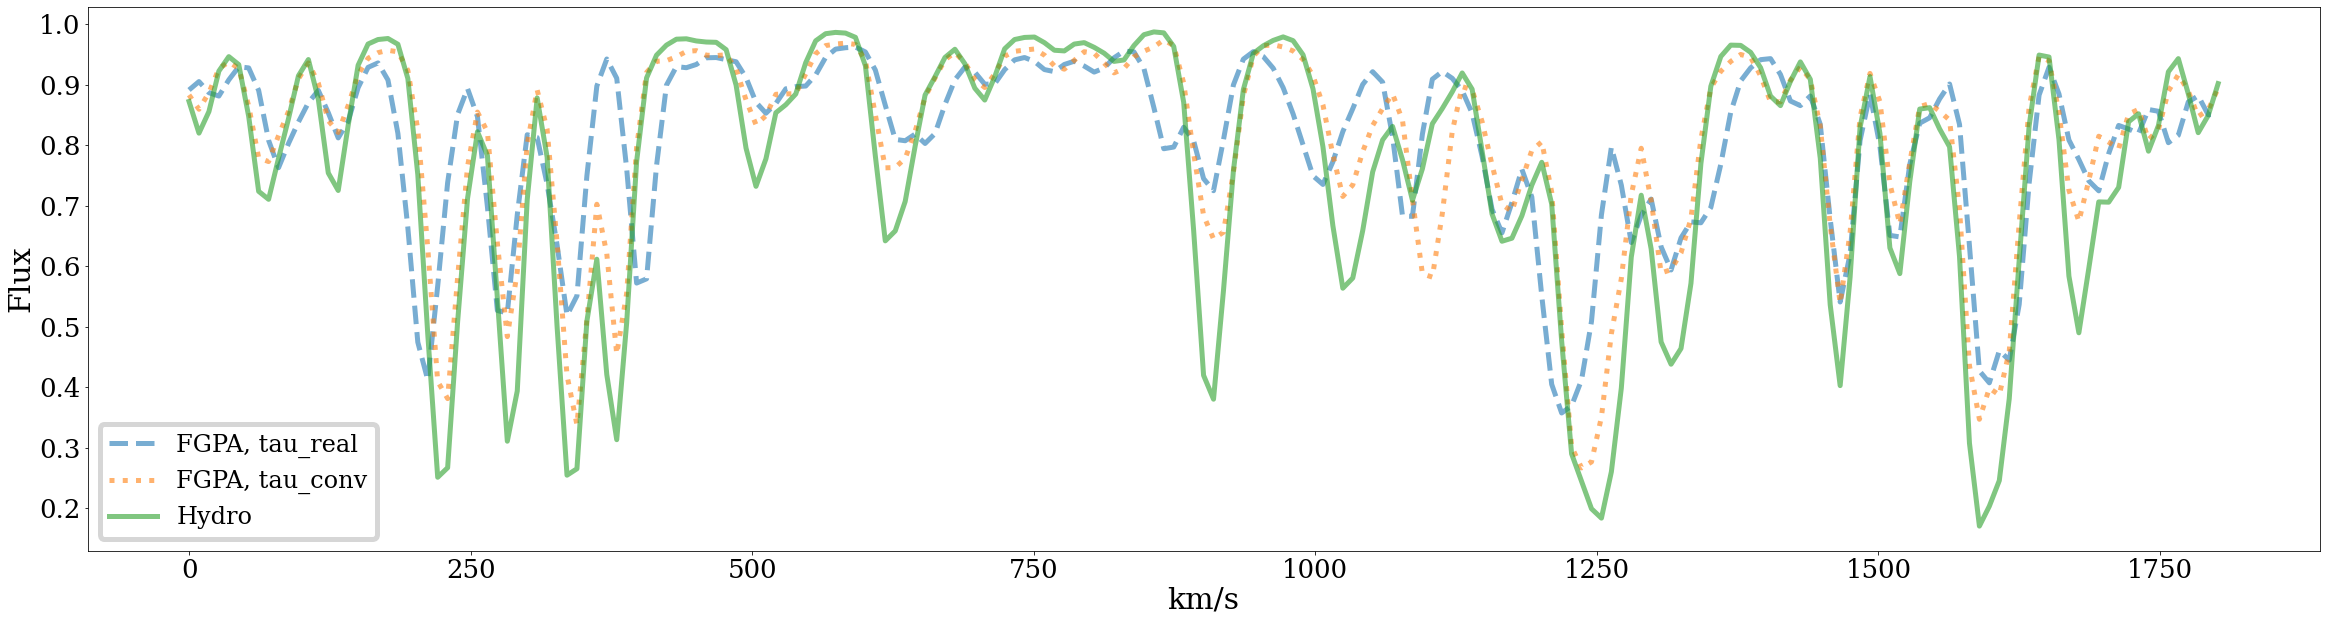

In [8]:
import importlib
from scipy.ndimage import gaussian_filter1d
import fake_spectra.fluxstatistics as fs
from codes import  fgpa
importlib.reload(fgpa)
def compare_real_conv():
    plt.figure(figsize=(40,10))
    z, boxsize, pix = 2.4442257045541464, 205, 12
    with h5py.File('../LyTomo_data/noiseless_maps/map_TNG_true_1.0_z2.4.hdf5',
                   'r') as ftrue :
        print(ftrue['redshift'][()])
        true_map = ftrue['flux'][:]
    with h5py.File('../LyTomo_data/FGPA/0_densfield.hdf5','r') as f:
        Nx = f['DM/dens'][:].shape[0]
        Ny = f['DM/dens'][:].shape[1]
        Nz = f['DM/dens'][:].shape[2]
        print(Nz)
        dvbin = cosmo.H(z).value*boxsize/(cosmo.h*Nz*(1+z))
        up = np.arange(Nz)*dvbin
        for (i,j) in [(60,60)] :
            dens = f['DM/dens'][i,j,:]
            ind = np.where(dens != 0)
            vel_pec = np.zeros_like(f['DM/Vz'][i,j,:])
            vel_pec[ind] = f['DM/Vz'][i,j,:][ind]/(dens[ind]*np.sqrt(1+z))
            vel_pec = gaussian_filter1d(vel_pec, 3)
            dens = gaussian_filter1d(dens,3)
            u0 = up + vel_pec

            tau_real = fgpa.get_tau_real(dens, z=z)
            tau_conv = np.empty_like(tau_real)
            btherm = fgpa.get_btherm(dens)
            # To avoide devision by 0, if b_threm == 0, pass a nonzero value since
            # tau_real is 0 in that voxel anyway; therefore tau_conv will be 0.
            btherm[np.where(btherm==0)] = 1
            
            for k in range(Nz) :
                # With periodic BC
                dvel = np.abs(up[k]-u0)
                indv = np.where(dvel > dvbin*Nz/2)
                dvel[indv] = dvbin*Nz - dvel[indv]
                Voight = (1/btherm)*np.exp(-(dvel/btherm)**2)
                tau_conv[k] = np.sum(tau_real*Voight*dvbin)
            scale = fs.mean_flux(tau_real, mean_flux_desired=0.8030459657915272)
            flux_real = np.array([np.sum(np.exp(-scale*tau_real[t*pix:(t+1)*pix]))
                                  /pix for t in range(int(Nz/pix)) ])
            scale = fs.mean_flux(tau_conv, mean_flux_desired=0.8030459657915272)
            flux_conv = np.array([np.sum(np.exp(-scale*tau_conv[t*pix:(t+1)*pix]))
                                  /pix for t in range(int(Nz/pix)) ])
            flux_real = gaussian_filter1d(flux_real, sigma=1, mode='wrap')
            flux_conv = gaussian_filter1d(flux_conv, sigma=1, mode='wrap')
            plt.plot(np.arange(flux_real.shape[0])*dvbin,flux_real,
                     label='FGPA, tau_real', alpha=0.6, ls='--')
            plt.plot(np.arange(flux_conv.shape[0])*dvbin,flux_conv,
                     label='FGPA, tau_conv', alpha=0.6, ls='dotted')
            
        flux_hydro = gaussian_filter1d(true_map[5,5,:], sigma=1, 
                                       mode='wrap')
        plt.plot(np.arange(flux_hydro.shape[0])*dvbin, flux_hydro, 
                 label='Hydro', alpha=0.6)
        
        plt.legend()
        plt.xlabel('km/s')
        plt.ylabel('Flux')
            
compare_real_conv()

### Optimal smoothing scales :

2.4442257045541464
2460
2.4442257045541464
2460
2.4442257045541464
2460
2.4442257045541464
2460


Text(0.5, 0, 'km/s')

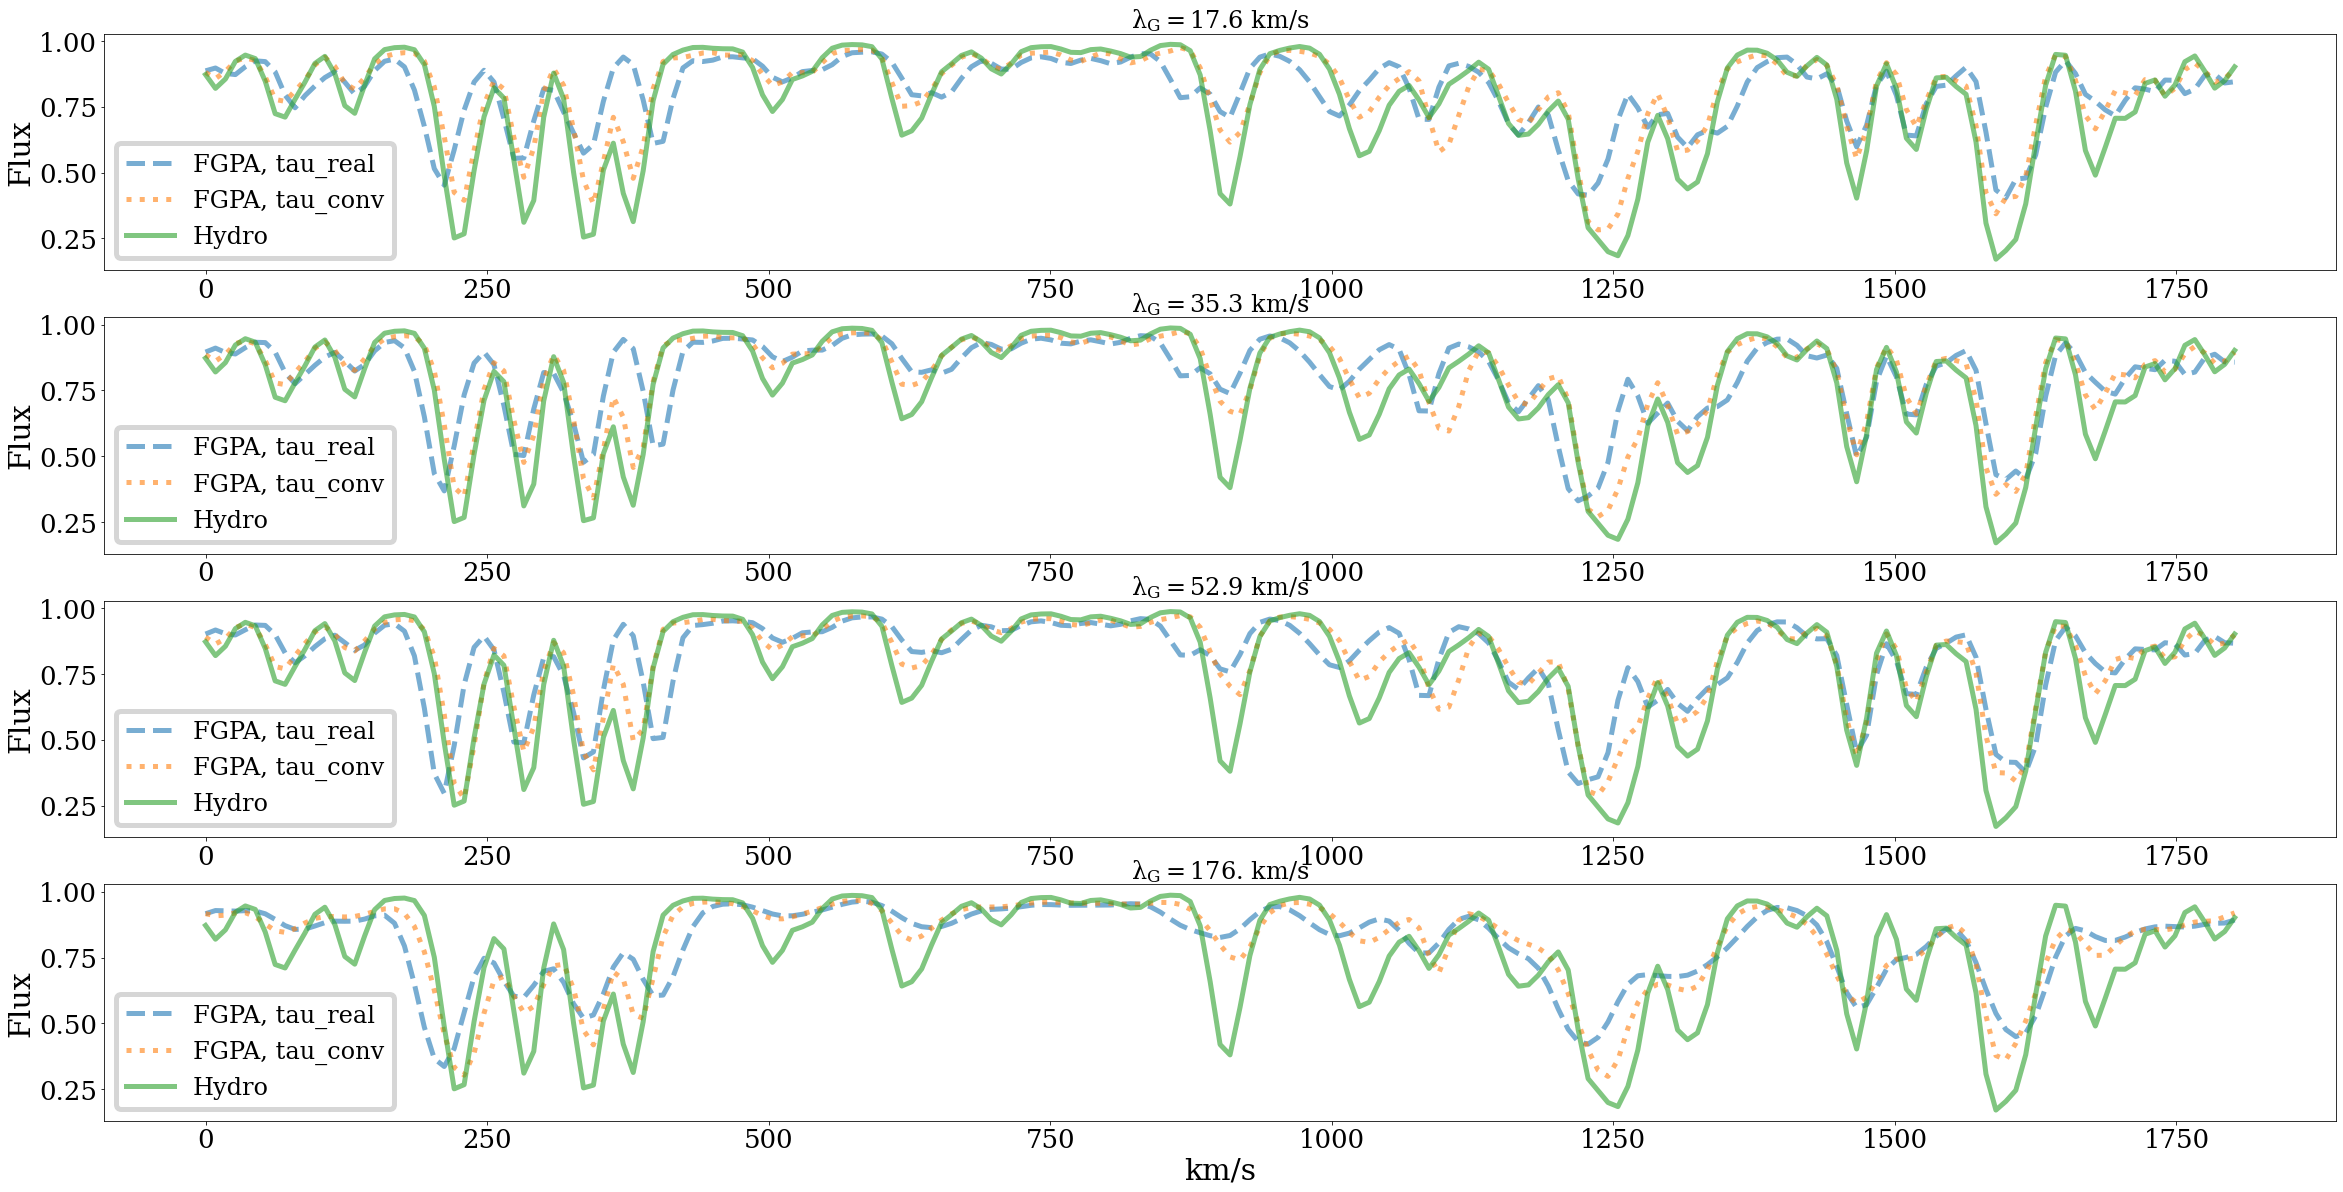

In [10]:
import importlib
from scipy.ndimage import gaussian_filter1d
import fake_spectra.fluxstatistics as fs
importlib.reload(fgpa)
def compare_real_conv(ax, lambda_G):
    z, boxsize, pix = 2.4442257045541464, 205, 12 
    with h5py.File('../LyTomo_data/noiseless_maps/map_TNG_true_1.0_z2.4.hdf5',
                   'r') as ftrue :
        print(ftrue['redshift'][()])
        true_map = ftrue['flux'][:]
    with h5py.File('../LyTomo_data/FGPA/0_densfield.hdf5','r') as f:
        Nx, Ny, Nz = f['DM/dens'][:].shape[0], f['DM/dens'][:].shape[1], f['DM/dens'][:].shape[2]
        print(Nz)
        dvbin = cosmo.H(z).value*boxsize/(cosmo.h*Nz*(1+z))
        up = np.arange(Nz)*dvbin
        for (i,j) in [(60,60)] :
            dens = f['DM/dens'][i,j,:]
            ind = np.where(dens != 0)
            vel_pec = np.zeros_like(f['DM/Vz'][i,j,:])
            vel_pec[ind] = f['DM/Vz'][i,j,:][ind]/(dens[ind]*np.sqrt(1+z))
            vel_pec = gaussian_filter1d(vel_pec, lambda_G)
            u0 = up + vel_pec
            dens = gaussian_filter1d(dens,lambda_G)
            

            tau_real = fgpa.get_tau_real(dens, z=z)
            tau_conv = np.empty_like(tau_real)
            btherm = fgpa.get_btherm(dens)
            # To avoide devision by 0, if b_threm == 0, pass a nonzero value since
            # tau_real is 0 in that voxel anyway; therefore tau_conv will be 0.
            btherm[np.where(btherm==0)] = 1
            
            for k in range(Nz) :
                # With periodic BC
                dvel = np.abs(up[k]-u0)
                indv = np.where(dvel > dvbin*Nz/2)
                dvel[indv] = dvbin*Nz - dvel[indv]
                Voight = (1/btherm)*np.exp(-(dvel/btherm)**2)
                tau_conv[k] = np.sum(tau_real*Voight*dvbin)
            scale = fs.mean_flux(tau_real, mean_flux_desired=0.8030459657915272)
            flux_real = np.array([np.sum(np.exp(-scale*tau_real[t*pix:(t+1)*pix]))
                                  /pix for t in range(int(Nz/pix)) ])
            scale = fs.mean_flux(tau_conv, mean_flux_desired=0.8030459657915272)
            flux_conv = np.array([np.sum(np.exp(-scale*tau_conv[t*pix:(t+1)*pix]))
                                  /pix for t in range(int(Nz/pix)) ])
            flux_real = gaussian_filter1d(flux_real, sigma=1, mode='wrap')
            flux_conv = gaussian_filter1d(flux_conv, sigma=1, mode='wrap') 
            ax.plot(np.arange(flux_real.shape[0])*dvbin,flux_real, 
                    label='FGPA, tau_real', alpha=0.6, ls='--')
            ax.plot(np.arange(flux_conv.shape[0])*dvbin,flux_conv, 
                    label='FGPA, tau_conv', alpha=0.6, ls='dotted')
            
        flux_hydro = gaussian_filter1d(true_map[5,5,:], sigma=1, mode='wrap')
        ax.plot(np.arange(flux_hydro.shape[0])*dvbin, flux_hydro, 
                label='Hydro', alpha=0.6)
        
        ax.legend()
        #ax.set_xlabel('km/s')
        ax.set_ylabel('Flux')
        ax.set_title(r'$\mathrm{\lambda_G = }$'+str(lambda_G*dvbin)[0:4]+' km/s')
fig, ax = plt.subplots(4,1, figsize=(40,20))
compare_real_conv(ax[0], lambda_G=2)
compare_real_conv(ax[1], lambda_G=4)
compare_real_conv(ax[2], lambda_G=6)
compare_real_conv(ax[3], lambda_G=20)
ax[3].set_xlabel('km/s')


- A reasonable smoothing scale seems good. The last row is too much of smoothing.
- However, in `power_spec.ipynb`, we found the sensitivity to $\lambda_G$ is marginal and fixing the mean flux for $\lambda_G = 1$ does the best in recovering the Hydro power spectrum. We should just go with that. CLAMATO and LATIS have not either tunded the initial smoothing scales. 

## Final FGPA map

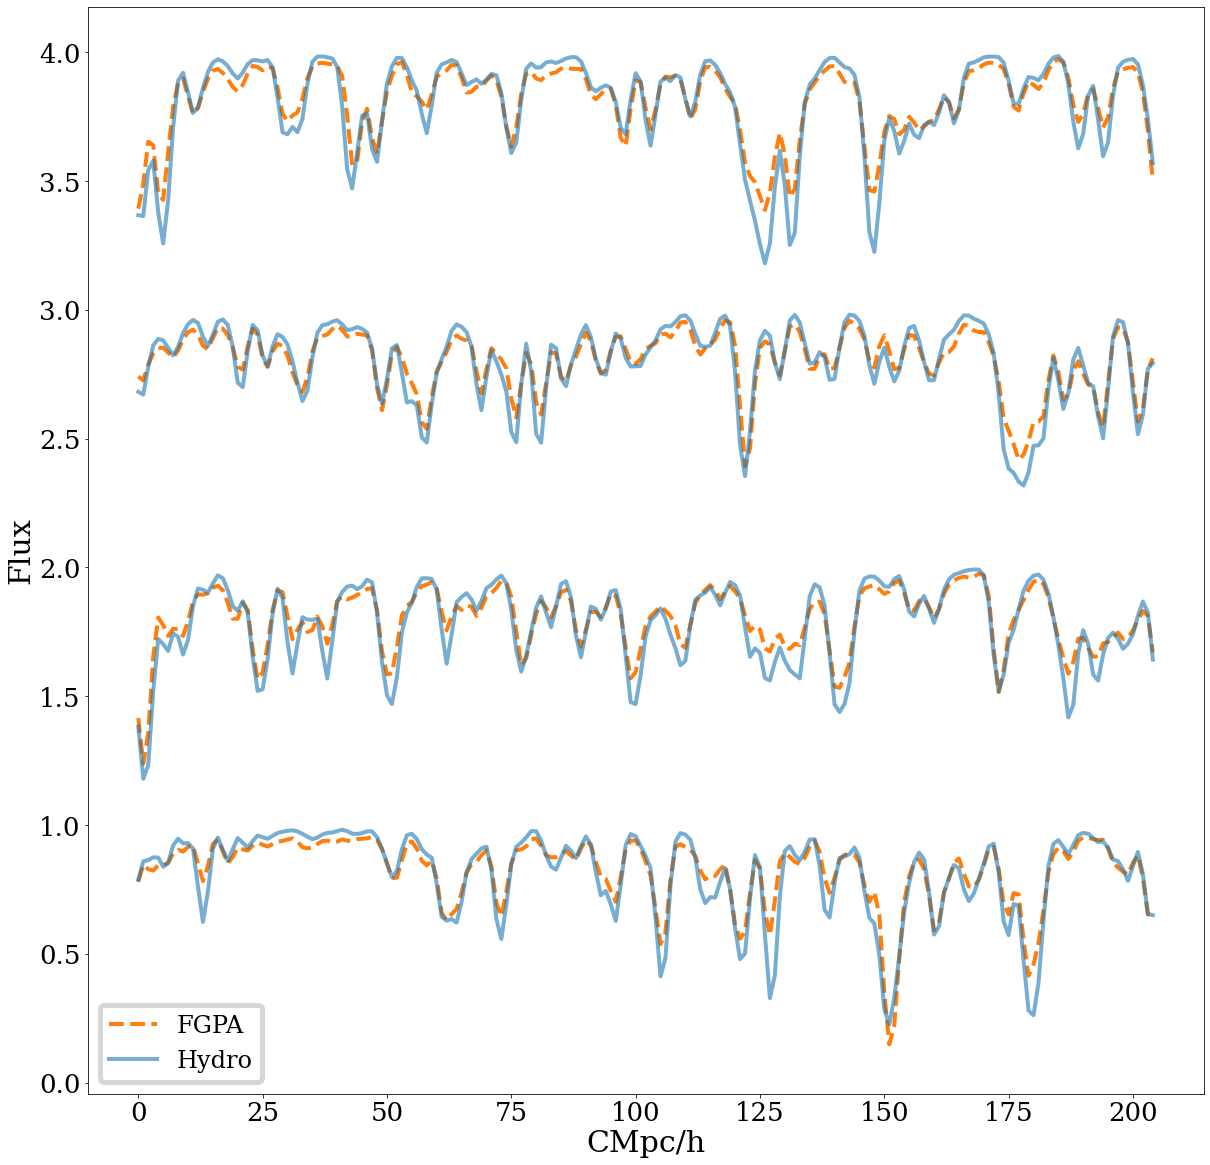

<Figure size 2880x720 with 0 Axes>

In [12]:
def test_full_map(ax):
    plt.figure(figsize=(40,10))
    x, y = [45,10,203, 50], [45,110,82,4] 
    with h5py.File('../LyTomo_data/noiseless_maps/map_TNG_true_1.0_z2.4.hdf5',
                   'r') as ftrue :
        with h5py.File('../LyTomo_data/FGPA/FGPA_DMonly_flux_z2.4.hdf5',
                       'r') as fDMonly:                
            true_map = gaussian_filter1d(ftrue['flux'][:],1, mode='wrap')
            for i in range(4) :
                ax.plot(i+fDMonly['map'][x[i],y[i],:], ls='--', label='FGPA', color='C1',lw=4)
                ax.plot(i+true_map[x[i],y[i],:], label='Hydro', alpha=0.6, color='C0',lw=4)
                ax.set_ylabel('Flux')
                if i==0:
                    ax.legend()

    ax.set_xlabel('CMpc/h')

fig, ax = plt.subplots(1,1, figsize=(20,20))
test_full_map(ax)
plt.tight_layout()
fig.savefig('./figures/Hydro_FGPA_spectra.pdf', transparent=True)

### Run watershed :

In [4]:
def run_watershed():
    import codes.minima as minima

    with h5py.File('../LyTomo_data/FGPA/FGPA_DM_only_flux_z2.4_MF_changed.hdf5','r') as f:
        fgpa_map = f['map'][:]
    with h5py.File('../LyTomo_data/DM_Density_field/TNG_DM_z2.4.hdf5','r') as f:
        DMconv = gaussian_filter(f['DM/dens'][:],sigma=4,mode='wrap')
    fgpa_map /= np.mean(fgpa_map)
    fgpa_map -= 1
    fgpa_map = gaussian_filter(fgpa_map,4, mode='wrap')
    peaks, lmap = minima.mtomo_partition_v2(fgpa_map, DMconv, thresh=-2.35,
                                            linking_contour=2.0)
    
    # Save it :
    with h5py.File('../LyTomo_data/lmap_FGPA_TNG_true_z2.4_MF_changed'+
                   +'.hdf5','w') as fw:
        fw['map'] = lmap
    with h5py.File('../LyTomo_data/FGPA/peaks_FGPA_TNG_true_z2.4_MF_changed'+
                   +'.hdf5','w') as fw:
        for a in list(peaks.keys())[0:16]:
            fw[a] = peaks[a]

run_watershed()

Using delta_dm = %0.3f dF**2 %0.4f dF + %0.4f (6.424995055553339, -3.7736627389421646, 0.7764580569349763)
Initially got 174 peaks, 
Periodic BC. Init num of countours:  155
Final Num of countours:  130
paernt  1 Num parts initial : 13 Num parts final: 13
paernt  3 Num parts initial : 3 Num parts final: 3
 contour4 hs no minima within it.
 contour5 hs no minima within it.
 contour6 hs no minima within it.
paernt  8 Num parts initial : 13 Num parts final: 13
 contour9 hs no minima within it.
paernt  10 Num parts initial : 2 Num parts final: 2
paernt  11 Num parts initial : 2 Num parts final: 2
paernt  12 Num parts initial : 7 Num parts final: 7
 contour13 hs no minima within it.
 contour14 hs no minima within it.
 contour15 hs no minima within it.
paernt  16 Num parts initial : 3 Num parts final: 3
 contour17 hs no minima within it.
 contour19 hs no minima within it.
paernt  21 Num parts initial : 2 Num parts final: 2
 contour22 hs no minima within it.
 contour23 hs no minima within it.

### Compare $M_{tomo}$ in true map :

In [7]:
def get_id_max_overlap(lmap1, lmap2):
    """
    returns : A dictionary of the corresponding ids of
    overlapping structures,just returns those structures
    which have overlapping structures in map2"""
    minima1 = np.unique(lmap1)
    minima2 = np.unique(lmap2)
    minima1 = np.delete(minima1, np.where(minima1==0))
    minima2 = np.delete(minima2, np.where(minima2==0))
    
    
    id_max_overlap = {'map1':np.array([]),'map2':np.array([]), 'no_overlap':np.array([])}
    id_no_overlap = np.array([])

    for i in minima1:
        indm = np.where(lmap1==i)
        ids, counts = np.unique(lmap2[indm], return_counts=True)
        if ids[0] == 0:
            ids = np.delete(ids, 0)
            counts = np.delete(counts, 0)
            if counts.size== 0 :
                id_max_overlap['no_overlap'] = np.append(id_max_overlap['no_overlap'], i)
                continue
        counts_sorted = np.sort(counts)
        # Here, If 2 sub-contours overlap identically, we pick just the one with lower id
        indt = np.where(counts == counts_sorted[-1])[0][0]
        if ids[indt]!=0 :
            id_max_overlap['map1'] = np.append(id_max_overlap['map1'], i)
            id_max_overlap['map2'] = np.append(id_max_overlap['map2'], ids[indt])
    id_max_overlap['map1'].astype(int)
    id_max_overlap['map2'].astype(int)
    return id_max_overlap

In [3]:
def get_Mtomo_FGPA_hydro(savefile=None, first_hydro=True):
    import os
    data_dir = '/run/media/mahdi/HD2/Lya/LyTomo_data/'
    lmap_fgpa = h5py.File(os.path.join(data_dir,'FGPA/lmap_FGPA_TNG_true_z2.4_MF_changed.hdf5'),
                          'r')['map'][:]
    lmap_hydro = h5py.File(os.path.join(data_dir,'watersheds_z2.4/noiseless/labeled_map_TNG_true'
                                        +'_z2.4_n1_sigma4_th2.35_lc2.00.hdf5'),'r')['map'][:]
    
    if first_hydro:
        id_max_overlap = get_id_max_overlap(lmap_hydro, lmap_fgpa)
    else:
        id_max_overlap = get_id_max_overlap(lmap_fgpa, lmap_hydro)
    del lmap_hydro, lmap_fgpa
    
    peaks_hydro = h5py.File(os.path.join(data_dir,'watersheds_z2.4/noiseless/peaks_TNG_true'
                                         +'_z2.4_n1_sigma4_th2.35_lc2.00.hdf5'),'r')
    peaks_fgpa = h5py.File(os.path.join(data_dir,'FGPA/peaks_FGPA_TNG_true_z2.4_MF_'
                                        +'changed.hdf5'),'r')
    
    mtomo_hydro = peaks_hydro['mtomo'][:]
    mtomo_fgpa = peaks_fgpa['mtomo'][:]
    if first_hydro :
        mtomo_fgpa_overlap = mtomo_fgpa[id_max_overlap['map2'].astype(int)-1]
        mtomo_hydro_overlap = mtomo_hydro[id_max_overlap['map1'].astype(int)-1]
        signif = peaks_hydro['signif'][:][id_max_overlap['map1'].astype(int)-1]
    else :
        mtomo_fgpa_overlap = mtomo_fgpa[id_max_overlap['map1'].astype(int)-1]
        mtomo_hydro_overlap = mtomo_hydro[id_max_overlap['map2'].astype(int)-1]
        signif = peaks_hydro['signif'][:][id_max_overlap['map2'].astype(int)-1]
    
    if savefile is not None:
        fw = h5py.File(savefile,'w')
        fw['MtomoHydro'] = mtomo_hydro_overlap
        fw['MtomoFGPA'] = mtomo_fgpa_overlap
        fw['Signif'] = signif
    else :
        return(mtomo_hydro, mtomo_fgpa, mtomo_hydro_overlap, 
               mtomo_fgpa_overlap, id_max_overlap, signif)


In [10]:
def plot_Mtomo_fgpa_hydro(fig, ax, first_hydro=True):
    
    _, _ , mtomo_hydro_overlap, mtomo_fgpa_overlap, _, signif = get_Mtomo_FGPA_hydro(savefile=None,
                                                                                     first_hydro=True)
    ind1 = (signif > -2.5)*(signif < -2.0)
    ind2 = (signif > -3.0)*(signif < -2.5)
    ind3 = (signif > -3.5)*(signif < -3.0)
    ind4 = (signif < -3.5)

    ax.plot([12,16], [12,16], color='r', label='1:1', ls='--', alpha=0.6)

    ax.scatter( mtomo_hydro_overlap[ind1], mtomo_fgpa_overlap[ind1],  alpha=0.7, 
               label=r'$-2.35 < \rm \delta_F / \sigma_{map} < -2.0$', marker= '^', 
               s=100, facecolor="None", edgecolor='C0', linewidth=2)
    ax.scatter( mtomo_hydro_overlap[ind2], mtomo_fgpa_overlap[ind2],  alpha=0.7,
               label=r'$-3.0 <  \rm \delta_F / \sigma_{map} < -2.5$', marker= 's',
               s=100, facecolor='None', edgecolor='C1', linewidth=2)
    ax.scatter( mtomo_hydro_overlap[ind3], mtomo_fgpa_overlap[ind3],  alpha=0.7, 
               label=r'$-3.5 <  \rm \delta_F / \sigma_{map} < -3.0$', marker = 'o',
               s=100, facecolor='None', edgecolor='C2', linewidth=2)
    ax.scatter( mtomo_hydro_overlap[ind4], mtomo_fgpa_overlap[ind4], alpha=0.7, 
               label=r'$ \  \rm \delta_F / \sigma_{map} < -3.5 $', marker ='D', 
               s=100, facecolor='None', edgecolor='C3', linewidth=2)


    ax.set_xlabel(r'$\mathrm{log [ M_{tomo} (Hydro) ]}$')
    ax.set_ylabel(r'$\mathrm{log [ M_{tomo} (FGPA) ]}$')
    ax.set_xlim(13.0,15.5)
    ax.legend(framealpha=0, fontsize=18)

    ax.set_ylim(13,15.5)
    ax.grid(True, alpha=0.6)
    plt.setp(ax.get_xticklabels(), rotation=40)

def get_erros_Mtomo_fgpa(bins = np.append(np.array([13.5]), np.arange(14,15.5,0.25))):
    """A method to get the statistics on FGPa-Hydro Mtomo comparision"""
    
    from astropy.stats import sigma_clip
    from astropy.stats import sigma_clipped_stats
    outlier_frac, median, std = [], [], []
    mbins = []
    (mtomo_hydro, _ , mtomo_hydro_overlap, mtomo_fgpa_overlap,
     id_max_overlap, _) =  get_Mtomo_FGPA_hydro(savefile=None)
    def cenfunc(data, axis=None):
        return 0
    for i, b in enumerate(np.arange(bins.size-1)):
        ind_all = np.where((mtomo_hydro < bins[b+1])*(mtomo_hydro > bins[b]))[0]
        mbins.append((bins[b+1]+bins[b])/2)
        ind = np.isin(id_max_overlap['map1'], ind_all+1)
        
        # To find outliers, we look for strucutres with a deviation in measurement larger than 3 times of
        # our error in Mtomo-MDM realtion
        dev = mtomo_fgpa_overlap[ind] - mtomo_hydro_overlap[ind]
        std_mtomo = np.array([0.36, 0.33, 0.29])
        not_outlier = np.where(np.abs(dev) < 3*std_mtomo[i])[0]
        outlier_frac.append(1 - not_outlier.size / ind_all.size)
        _, MedianSigClip, StdSigClip = sigma_clipped_stats(dev, sigma=3, maxiters=None, 
                                                           cenfunc=cenfunc)
        median.append(MedianSigClip)
        std.append(StdSigClip)

    return median, std, outlier_frac

The errors afer fixing the mean flux in FGPA to match the power spectrum with Hydro :

In [8]:
median, std, outlier_frac = get_erros_Mtomo_fgpa(bins=np.array([13.5,14,14.5,15.5]))
print('IN mass bins Median', median ,  'RMS = : ', std, 'Outlier fraction (not overlapping or an error larger than 3*std) = ', outlier_frac)

IN mass bins Median [-0.01214431867734067, -0.06394055871718685, -0.12949701311866146] RMS = :  [0.5156112206268844, 0.2706775003289894, 0.1327335805138572] Outlier fraction (not overlapping or an error larger than 3*std) =  [0.2857142857142857, 0.0, 0.0]


- The quality of FGPA is worse for low mas sstructures. We can tell FGPA is merging some strucutres since it does not capture all minima wuthin the map. 



In [13]:
def print_on_overlaps():
    lmap_hydro = h5py.File('../LyTomo_data/watersheds_z2.4/noiseless/'
                           +'labeled_map_TNG_true_z2.4_n1_sigma4_th2.35'
                           +'_lc2.00.hdf5','r')['map'][:]
    lmap_fgpa = h5py.File('../LyTomo_data/FGPA/lmap_FGPA_TNG_true_z2.4_MF'
                          +'_changed.hdf5','r')['map'][:]
    peaks_hydro = h5py.File('../LyTomo_data/watersheds_z2.4/noiseless/'
                            +'peaks_TNG_true_z2.4_n1_sigma4_th2.35_lc2.00.hdf5','r')
    peaks_fgpa = h5py.File('../LyTomo_data/FGPA/peaks_FGPA_TNG_true_z2.4_MF_changed'
                          +'.hdf5','r')
    id_no_overlap={'fgpa':[], 'hydro':[]}
    id_no_overlap['fgpa'] = get_id_max_overlap(lmap1=lmap_fgpa, 
                                               lmap2=lmap_hydro)['no_overlap']
    id_no_overlap['hydro'] = get_id_max_overlap(lmap1=lmap_hydro, 
                                                lmap2=lmap_fgpa)['no_overlap']
    print(id_no_overlap)
    print(id_no_overlap['fgpa'].size / peaks_fgpa['x'].size)
    print(id_no_overlap['hydro'].size / peaks_hydro['x'].size)
print_on_overlaps()

{'fgpa': array([146., 149., 157., 160., 162., 166., 167., 168., 171.]), 'hydro': array([153., 159., 168., 176., 177., 178., 179., 184.])}
0.05172413793103448
0.043478260869565216


Write down the id of the outliers to indicate on map :

### Gaussian KDE :

It helps to find the mass cut where FGPa fails :

In [25]:
def kde_Mtomo_fgpa_hydro(fig, ax, MF_changed = True, first_hydro=True, legend=True, title=''):
    from scipy.stats import gaussian_kde as gkde
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    
    ax.plot([12,16], [12,16], color='r', label='1:1', ls='--', alpha=0.4)
    
    (_, _ , mtomo_hydro_overlap, mtomo_fgpa_overlap, _,
     signif) = get_Mtomo_FGPA_hydro(savefile=None, first_hydro=first_hydro)
    
    data = np.zeros((2,mtomo_hydro_overlap.size))
    data[0,:] = mtomo_hydro_overlap
    data[1,:] = mtomo_fgpa_overlap
    
    kernel = gkde(data)  
    
    X, Y = np.mgrid[13.2:15.5:50j, 13.2:15.5:50j]
    grid_points = np.vstack([X.ravel(), Y.ravel()])
    Z = np.reshape(kernel(grid_points).T, X.shape)
    del X, Y
    
    im = ax.imshow(np.rot90(Z), cmap=plt.cm.viridis, extent = [13, 16, 13, 16], vmin=0, vmax=1.8)
    if legend:
        axins = inset_axes(ax,width="100%", height="100%",  
                           bbox_to_anchor=(1.1,0.4, 0.6, 0.05), 
                           bbox_transform=ax.transAxes)
        cb = fig.colorbar(im, cax=axins, orientation='horizontal')
        cb.ax.set_xlabel('Gaussian KDE', labelpad=30)
        cb.set_ticks([0,0.9,1.8])
    
    ind1 = (signif > -2.5)*(signif < -2.0)
    ind2 = (signif > -3.0)*(signif < -2.5)
    ind3 = (signif > -3.5)*(signif < -3.0)
    ind4 = (signif < -3.5)


    ax.scatter( mtomo_hydro_overlap[ind1], mtomo_fgpa_overlap[ind1],  alpha=0.7,
               label=r'$-2.35 < \rm \delta_F / \sigma_{map} < -2.0$', marker= '^',
               s=50, facecolor="None", edgecolor='r', linewidth=2)
    ax.scatter( mtomo_hydro_overlap[ind2], mtomo_fgpa_overlap[ind2],  alpha=0.7, 
               label=r'$-3.0 <  \rm \delta_F / \sigma_{map} < -2.5$', marker= 's', 
               s=50, facecolor='None', edgecolor='C1', linewidth=2)
    ax.scatter( mtomo_hydro_overlap[ind3], mtomo_fgpa_overlap[ind3],  alpha=0.7, 
               label=r'$-3.5 <  \rm \delta_F / \sigma_{map} < -3.0$', marker = 'o',
               s=50, facecolor='None', edgecolor='violet', linewidth=2)
    ax.scatter( mtomo_hydro_overlap[ind4], mtomo_fgpa_overlap[ind4], alpha=0.7, 
               label=r'$ \  \rm \delta_F / \sigma_{map} < -3.5 $', marker ='D', 
               s=50, facecolor='None', edgecolor='w', linewidth=2)


    ax.set_xlabel(r'$\mathrm{log [ M_{tomo} (Hydro) ]}$')
    ax.set_ylabel(r'$\mathrm{log [ M_{tomo} (FGPA) ]}$')
    ax.set_title(title, pad=30)
    
    ax.set_xlim([13, 16])
    ax.set_ylim([13, 16])
    ax.set_xticks([13.5,14,14.5,15,15.5])
    ax.set_yticks([13.5,14,14.5,15,15.5])
    #ax.set_yticks([50,150,300])
    if legend:
        ax.legend(framealpha=1, fontsize=18, loc=(1.005, 0.5), facecolor='gray')
    
    ax.grid(True, alpha=0.6)
    plt.setp(ax.get_xticklabels(), rotation=40)

<ipython-input-26-be8591e2d050>:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


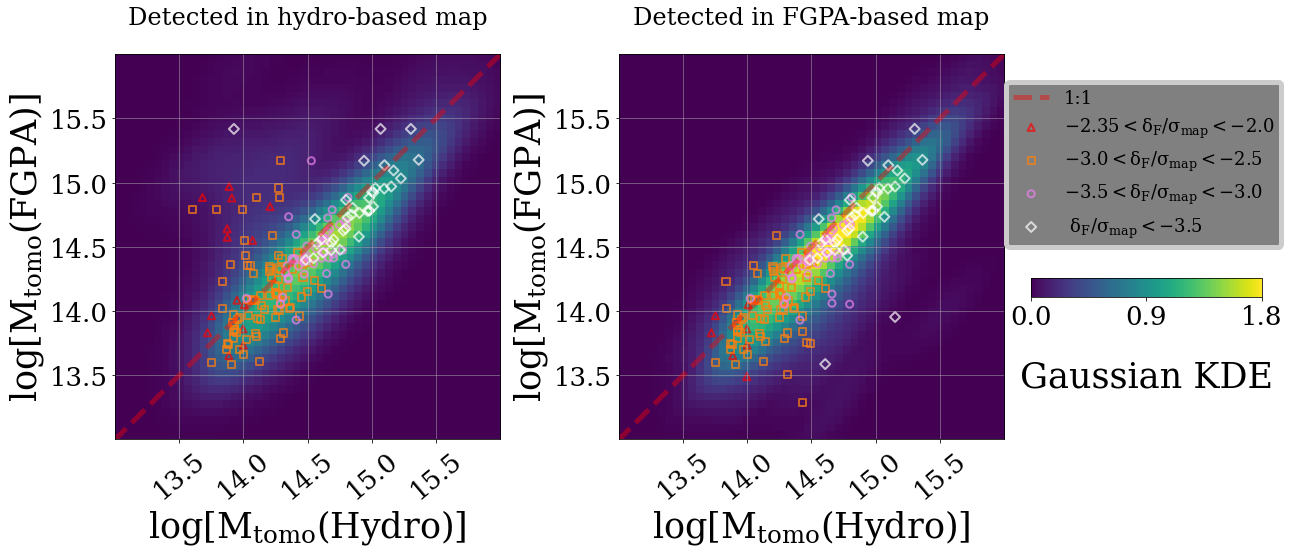

In [26]:
fig, ax = plt.subplots(1,2, figsize=(18,9))
kde_Mtomo_fgpa_hydro(fig, ax[0], first_hydro=True, legend=False, title='Detected in hydro-based map')
kde_Mtomo_fgpa_hydro(fig, ax[1], first_hydro=False, title='Detected in FGPA-based map')
fig.tight_layout()
fig.savefig('./figures/FGPA_hydro_Mtomo_kde.pdf')

### Characterizing the overmerging in FGPA :

In [39]:
def get_number_of_overmerged_watersheds():
    
    fig, ax = plt.subplots(1,2, figsize=(20,10))
    for first_hydro in [True, False]:
        (mtomo_hydro, mtomo_fgpa , mtomo_hydro_overlap, mtomo_fgpa_overlap,
         id_max_overlap, signif) = get_Mtomo_FGPA_hydro(first_hydro=first_hydro)
        
        _, unique_indices, counts = np.unique(id_max_overlap['map2'][:],
                                              return_counts=True, return_index=True)
        ind = np.where(counts!=1)[0]
        indices_merged = unique_indices[ind]
            
        if first_hydro:
            blended = np.sum(counts[ind])
            print('Number of blended watershesd in Hydro (Fraction) = ',
                  blended, blended/mtomo_hydro.size )
            #extra_blended = np.sum(counts[ind]) - ind.size
            #print('Number of blended watershesd in Hydro (Fraction) = ',
            #      extra_blended, extra_blended/mtomo_hydro.size )
            print('Number of blendings happening = ', 
                  indices_merged.size)
            label='blended'
            ls='solid'
        else:
            print('Number of deblended watersheds in Hydro (Fraction) = ',
                  indices_merged.size, indices_merged.size/mtomo_hydro.size)
            label='deblended'
            ls='--'
        
        ax[0].hist(np.unique(mtomo_hydro_overlap[indices_merged.astype(int)]),
                   bins=np.arange(12.75,16.5,0.25), histtype='step', label=label, ls=ls)

        if first_hydro:
            print('Number of watersheds have no overlap in Hydro', 
                  id_max_overlap['no_overlap'][:].size,
                  id_max_overlap['no_overlap'].size/mtomo_hydro.size)
            
            ax[1].hist(mtomo_hydro[id_max_overlap['no_overlap'][:].astype(int)-1],
                       bins=np.arange(12.75,16.5,0.5), histtype='step', label='Hydro')
        else:
            print('Number of watersheds have no overlap in FGPA', 
                  id_max_overlap['no_overlap'][:].size, 
                  id_max_overlap['no_overlap'].size/mtomo_fgpa.size)
            ax[1].hist(mtomo_fgpa[id_max_overlap['no_overlap'][:].astype(int)-1],
                       bins=np.arange(12.75,16.5,0.5), histtype='step',
                       label='FGPA', ls='--')
    
    ax[0].set_xlabel(r'$\rm M_{tomo, Hydro}$')
    ax[0].set_ylabel('Count')
    ax[1].set_xlabel(r'$\rm M_{tomo}$')
    ax[1].set_ylabel('Count')
    ax[1].set_title('no overlap')
    ax[0].legend(loc='upper left', framealpha=0)
    ax[1].legend()
    ax[1].set_ylim((0,8))
    ax[0].set_xticks(np.arange(13, 16, 0.5))
    ax[0].grid(True)
    ax[1].grid(True)

Number of blended watershesd in Hydro (Fraction) =  40 0.21739130434782608
Number of blendings happening =  17
Number of watersheds have no overlap in Hydro 8 0.043478260869565216
Number of deblended watersheds in Hydro (Fraction) =  12 0.06521739130434782
Number of watersheds have no overlap in FGPA 9 0.05172413793103448


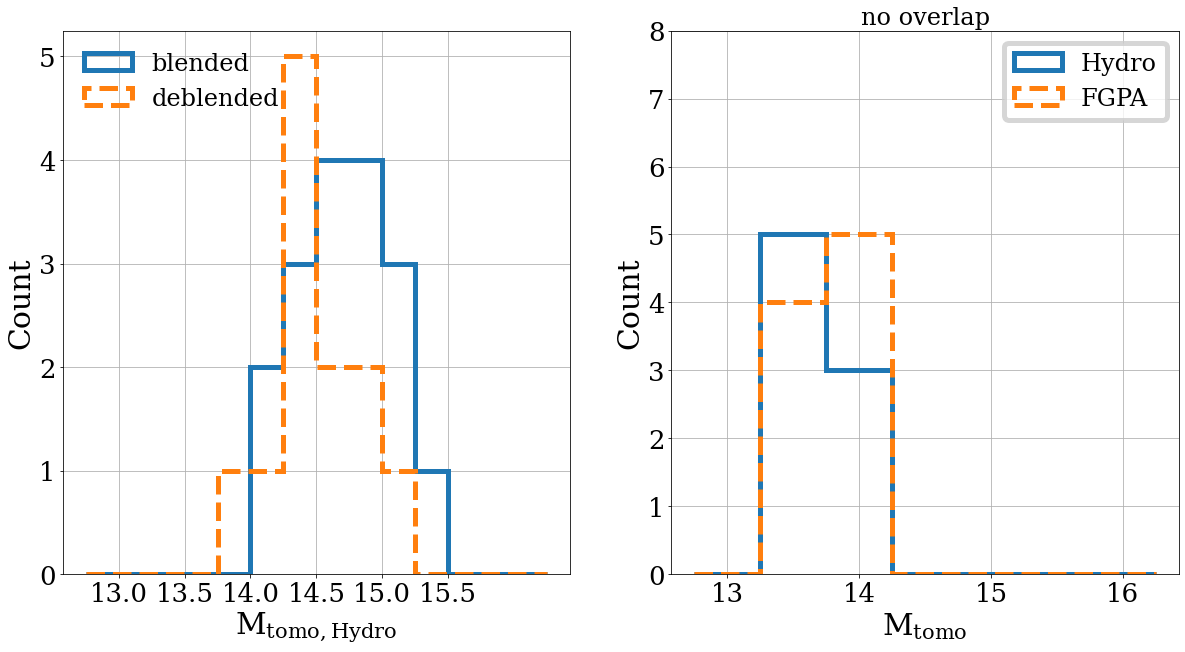

In [40]:
get_number_of_overmerged_watersheds()

So :

- It might be slightly more likely FGPA merges watersheds than breaking watersheds into smaller pieces.

- The watersheds belnded by FGPA might be slightly more massvie than those deblended by FGPA. The difference may be very marginal. 

- The watersheds FGPA fakely produces might be slightly more massive than watersheds in Hydro which FGPA missed to indentify.

All the 3 above arguments are not strong enough due to small smaple size, so we did not bring them in the paper. But we are sure however that a fraction ($> 10 \%$ or $\sim 20 \%$)of the strcuutres are either blennded or deblended in the FGPA map. There are signs of this from comparing the spectra [here](#Final-FGPA-map) .


## On voxel level :

In [1]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
from astropy.cosmology import Planck15 as cosmo
from scipy.ndimage import gaussian_filter as gf
import matplotlib
import lytomo_watershed as ltw
plt.style.use('Notebook.mystyle')

In [2]:
def get_2d_hist(DM_file, sigma, deltaF_file=None, F_file=None):
    """Get 2d hist for deltaF vs rho_DM"""
    bins=[np.linspace(-1,3,200), np.linspace(-.4,.2,75)]
    if deltaF_file is not None :
        #deltaF = np.transpose(h5py.File(deltaF_file,'r')['map'][:], (1,0,2))
        deltaF = h5py.File(deltaF_file,'r')['map'][:]
        deltaF = np.ravel(gf(deltaF, sigma, mode='wrap'))
    if F_file is not None:
        F = h5py.File(F_file,'r')['map'][:]
        deltaF = F/np.mean(F) - 1
        deltaF = np.ravel(gf(deltaF, sigma, mode='wrap'))
    
    DM = np.ravel(gf(h5py.File(DM_file,'r')['DM/dens'][:], 
                     sigma , mode='wrap'))
    print('deltaF:', deltaF.shape)
    print('DM:', DM.shape)
    h,_, _ = np.histogram2d( DM-1, deltaF, bins=[bins[0],bins[1]], density=True)
    
    return bins, h

def deltaF_rhoDM(fig, ax, sigma, deltaF_file=None, F_file=None,
                 DM_file='./LyTomo_data/DM_Density_field/TNG_DM_z2.6.hdf5', vmin=0.01):
    """Plot a colormap for the 2d hist for deltaF vs rho_DM"""
    #matplotlib.rc('axes',edgecolor='w')
    
    # Set the axes
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    
    bins, h = get_2d_hist(DM_file=DM_file, sigma=sigma, deltaF_file=deltaF_file, F_file=F_file)
    extent = ([bins[0][0], bins[0][-1], bins[0][0], bins[0][-1]],
              [bins[0][0], bins[0][-1], bins[1][0], bins[1][-1]])
    
    h[h < vmin] = vmin
    im = ax.imshow(np.rot90(h), cmap=plt.cm.viridis, 
                   norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=10),
                   extent = extent[1], aspect='auto' )
    axins = inset_axes(ax,width="100%", height="100%",  
                       bbox_to_anchor=(0.9,0.5, 0.02, 0.4),
                       bbox_transform=ax.transAxes)
    cb_ticks_pos = 'left'
    cb = fig.colorbar(im, cax=axins, orientation='vertical', ticks=[1e-2,1e-1, 1, 10,100])
    cb.ax.yaxis.set_tick_params(color='k')
    cb.ax.yaxis.set_ticks_position(cb_ticks_pos)
    cb.ax.yaxis.set_label_position(cb_ticks_pos)
    plt.setp(plt.getp(axins, 'yticklabels'), color='w')
    cb.ax.set_ylabel('2-D PDF', labelpad=5, color='w', fontsize=20)
    
    ax.set_xlabel(r'$\mathrm{\delta^{\rm sm}_{\rm F, mock}}$')
    ax.set_ylabel(r'$\rm  \left(\frac{\rho_{DM}}{ \langle \rho_{DM} \rangle}\right)^{\rm sm}$', fontsize=40)
    ax.set_xlim(-0.35,0.25)
    ax.set_ylim(0,3.5)
    ax.set_xticks(ticks = np.arange(-.3,.3,.1))
    plt.setp(ax.get_xticklabels(), rotation=20, fontsize=20)
    
    ax.grid(True)


In [3]:
def deltaF_rhoDM_contours(fig, ax, sigma, DM_file, ls='solid', color='C0', deltaF_file=None, F_file=None, label='c'):
    bins, h = get_2d_hist(DM_file=DM_file, sigma=sigma, deltaF_file=deltaF_file, F_file=F_file)
    
    xmbin = [(bins[0][b]+bins[0][b+1])/2 for b in range(len(bins[0])-1)]
    ymbin = [(bins[1][b]+bins[1][b+1])/2 for b in range(len(bins[1])-1)]
    X, Y = np.meshgrid(xmbin,ymbin)
    
    cs = ax.contour(X.T, Y.T, h, levels=[0.02, 0.68, 0.98], linestyles=ls, colors=color)

    cs.collections[1].set_label(label)
    ax.set_xlim(bins[0][0]-0.05, bins[0][-1]+0.05)
    ax.set_ylim(bins[1][0]-0.05, bins[1][-1]+0.05)
    ax.set_ylabel(r'$\mathrm{\delta^{sm}_{F}}$')
    ax.set_xlabel(r'$(\rho_{\rm DM}/<\rho_{\rm DM}>)^{sm} - 1$')
    ax.grid(True)
    ax.legend(loc='upper right')
    

At z=2.6, withour chaning the mean flux in FGPA to math the powerspectrum in hydro, we get :

deltaF: (8615125,)
DM: (8615125,)
deltaF: (8615125,)
DM: (8615125,)


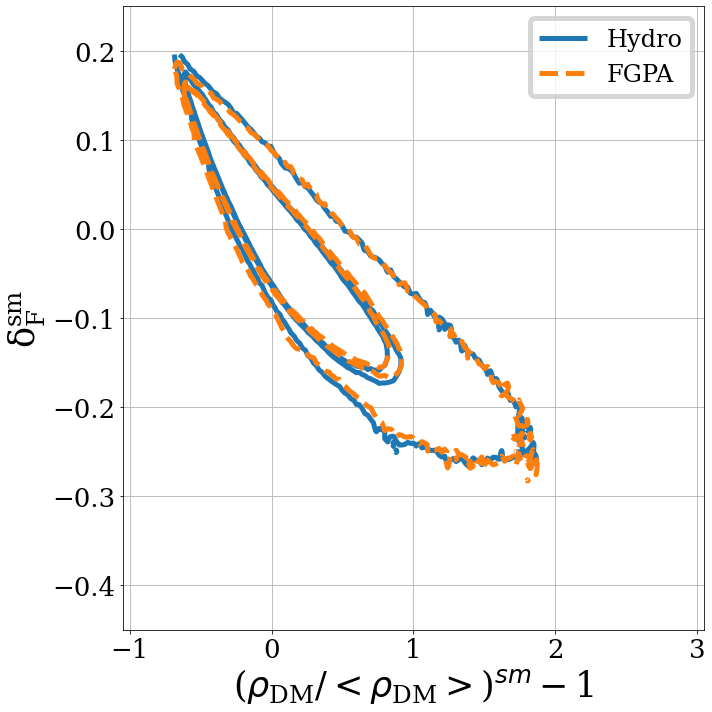

In [18]:
fig, ax= plt.subplots(1,1)
import os
data_dir = '/run/media/mahdi/HD2/Lya/LyTomo_data/'
deltaF_rhoDM_contours(fig, ax, sigma=4, DM_file=os.path.join(data_dir,'DM_Density_field/TNG_DM_z2.4.hdf5'),
                      deltaF_file='/run/media/mahdi/HD2/Lya/spectra/TNG300/map_TNG300_1.0Mpc.hdf5',
                      label='Hydro')
#deltaF_file=os.path.join(data_dir,'noiseless_maps/map_TNG_true_1.0_z2.4.hdf5'
deltaF_rhoDM_contours(fig, ax, sigma=4,DM_file=os.path.join(data_dir,'DM_Density_field/TNG_DM_z2.4.hdf5'),
                      F_file='/run/media/mahdi/HD2/Lya/spectra/FGPA_z2.6_1.0.hdf5',ls='--',
                      color='C1', label='FGPA')
#'/run/media/mahdi/HD2/Lya/FGPA_fixed/densfield/FGPA_z2.4_1.0_new.hdf5
#F_file=os.path.join(data_dir,'FGPA/FGPA_DMonly_flux_z2.4.hdf5'), ls='--',
fig.tight_layout()
fig.savefig('./figures/FGPA_Hydro_field.pdf')

- [ ] I should correct the FGPA maps after changing the bug in FGPA (i.e. ** vs *)

At z=2.4 :

deltaF: (8615125,)
DM: (8615125,)
deltaF: (8615125,)
DM: (8615125,)


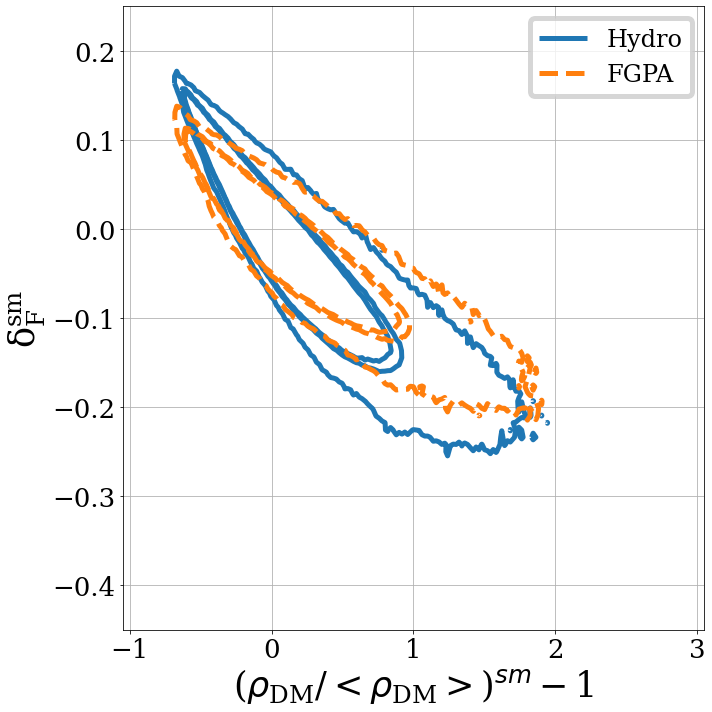

In [33]:
fig, ax= plt.subplots(1,1)
import os
data_dir = '/run/media/mahdi/HD2/Lya/LyTomo_data/'
deltaF_rhoDM_contours(fig, ax, sigma=4, DM_file=os.path.join(data_dir,'DM_Density_field/TNG_DM_z2.4.hdf5'),
                      deltaF_file=os.path.join(data_dir,'noiseless_maps/map_TNG_true_1.0_z2.4.hdf5'),
                      label='Hydro')

deltaF_rhoDM_contours(fig, ax, sigma=4,DM_file=os.path.join(data_dir,'DM_Density_field/TNG_DM_z2.4.hdf5'),
                      F_file=os.path.join(data_dir,'FGPA/FGPA_DMonly_flux_z2.4.hdf5'), ls='--',
                      color='C1', label='FGPA')
fig.tight_layout()
#fig.savefig('./figures/FGPA_Hydro_field.pdf')

The fig above stilll uses the old maps with the '*' vs'**' error.

Generating new FGPA maps :

1. We set Md same as Hydro :

deltaF: (8615125,)
DM: (8615125,)
deltaF: (8615125,)
DM: (8615125,)


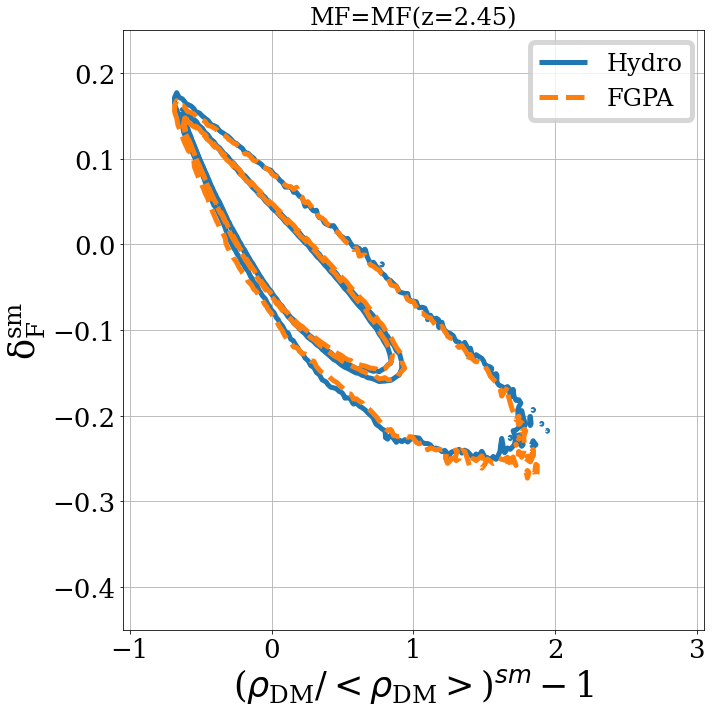

In [7]:
fig, ax= plt.subplots(1,1)
import os
data_dir = '/run/media/mahdi/HD2/Lya/LyTomo_data/'
deltaF_rhoDM_contours(fig, ax, sigma=4, DM_file=os.path.join(data_dir,'DM_Density_field/TNG_DM_z2.4.hdf5'),
                      deltaF_file=os.path.join(data_dir,'noiseless_maps/map_TNG_true_1.0_z2.4.hdf5'),
                      label='Hydro')

deltaF_rhoDM_contours(fig, ax, sigma=4,DM_file=os.path.join(data_dir,'DM_Density_field/TNG_DM_z2.4.hdf5'),
                      F_file=os.path.join('/run/media/mahdi/HD2/simulations/TNG300-1/postprocessing/FGPA/densfield/FGPA_z2.4_1.0.hdf5'), ls='--',
                      color='C1', label='FGPA')
ax.set_title('MF=MF(z=2.45)')
fig.tight_layout()
#fig.savefig('./figures/FGPA_Hydro_field.pdf')

2. We set MF=0.75 to match tthe powerspectrum od hydro.

deltaF: (8615125,)
DM: (8615125,)
deltaF: (8615125,)
DM: (8615125,)


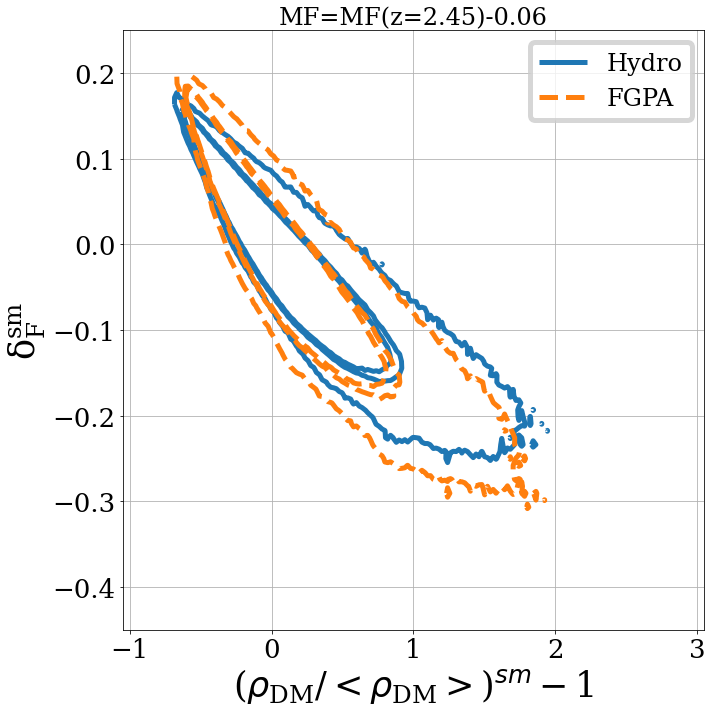

In [8]:
fig, ax= plt.subplots(1,1)
import os
data_dir = '/run/media/mahdi/HD2/Lya/LyTomo_data/'
deltaF_rhoDM_contours(fig, ax, sigma=4, DM_file=os.path.join(data_dir,'DM_Density_field/TNG_DM_z2.4.hdf5'),
                      deltaF_file=os.path.join(data_dir,'noiseless_maps/map_TNG_true_1.0_z2.4.hdf5'),
                      label='Hydro')

deltaF_rhoDM_contours(fig, ax, sigma=4,DM_file=os.path.join(data_dir,'DM_Density_field/TNG_DM_z2.4.hdf5'),
                      F_file=os.path.join('/run/media/mahdi/HD2/simulations/TNG300-1/postprocessing/FGPA/densfield/FGPA_z2.4_1.0_MF.75.hdf5'), ls='--',
                      color='C1', label='FGPA')
ax.set_title('MF=MF(z=2.45)-0.06')
fig.tight_layout()
#fig.savefig('./figures/FGPA_Hydro_field.pdf')

Sth is deeply wrong with the current FGPA code !

In [49]:
def test_FGPA():
    f=h5py.File('/run/media/mahdi/HD2/Lya/FGPA_fixed/densfield/FGPA_z2.4_1.0_MF.75.hdf5','r')
    print(np.mean(f['map'][:]))
    f.close()
    f=h5py.File('/run/media/mahdi/HD2/Lya/FGPA_fixed/densfield/FGPA_z2.4_1.0.hdf5','r')
    print(np.mean(f['map'][:]))
    f.close()
    f=h5py.File('/run/media/mahdi/HD2/Lya/FGPA_fixed/densfield/FGPA_z2.4_1.0_No_MF_fix.hdf5','r')
    print(np.mean(f['map'][:]))
test_FGPA()

0.9786555621653791
0.9838118592145483
0.9838118592145483
